## Process Total Precipitation

In this notebook, previously prepared monthly total precipitation data is further processed to retrieve yearly and spatially aggregated total values. The following steps are included:
- Use monthly summed ERA5-Land data that has been cropped to NL / BL forest area
- Calculate yearly summed values for each pixel
- Spatially aggregate precipitation for each federal state to retrieve summed value per state and year

In [1]:
# import libraries
import os
import glob
import xarray as xr
import pandas as pd
import geopandas as gpd
import rasterio
import odc.stac
import pathlib
from pathlib import Path
import warnings

In [2]:
# set working directory
os.chdir("E:/Master/Thesis/3_Data")
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: E:\Master\Thesis\3_Data


In [3]:
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [4]:
# create list with forest types
forest_types = ("NL", "BL")

In [ ]:
# loop over years to calculate yearly summed values per pixel

for year in range(1981, 2025):
    
    # process needleleaved and broadleaved forest
    for f in range(len(forest_types)):
        forest_type = forest_types[f]

        # get file of according year that belongs to forest type
        directory = "./Climate/Precipitation/Monthly"
        files = glob.glob(os.path.join(directory, f"*{year}_{forest_type}*.nc"))

        # glob returns a list, we only want the string with the filepath
        file = str(files[0])

        # open netCDF dataset of corresponding year with all monthly datasets
        tp = xr.open_dataset(file, decode_coords="all", decode_times=True, engine = "netcdf4")
        
        # calculate yearly summed values
        tp_year_sum = tp.resample(time="1YS", skipna=True).sum("time")

        # change unit in variable attributes
        tp_year_sum.tp.attrs["units"] = "mm/year"

        # compress data to reduce size
        comp = dict(zlib=True, complevel=4)
        tp_year_sum.tp.encoding.update(comp)

        # save created dataset as netCDF4 files
        tp_year_sum.to_netcdf(f"./Climate/Precipitation/Yearly/tp_year_sum_{year}_{forest_type}.nc")

In [6]:
# look at exemplary dataset to get an overview
tp_year_sum

<xarray.Dataset> Size: 83MB
Dimensions:      (time: 1, lat: 2952, lon: 3510)
Coordinates:
    spatial_ref  int64 8B ...
  * lon          (lon) float64 28kB 5.451 5.454 5.457 5.46 ... 15.19 15.2 15.2
  * lat          (lat) float64 24kB 55.2 55.2 55.19 55.19 ... 47.01 47.0 47.0
  * time         (time) datetime64[ns] 8B 2024-01-01
Data variables:
    tp           (time, lat, lon) float64 83MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

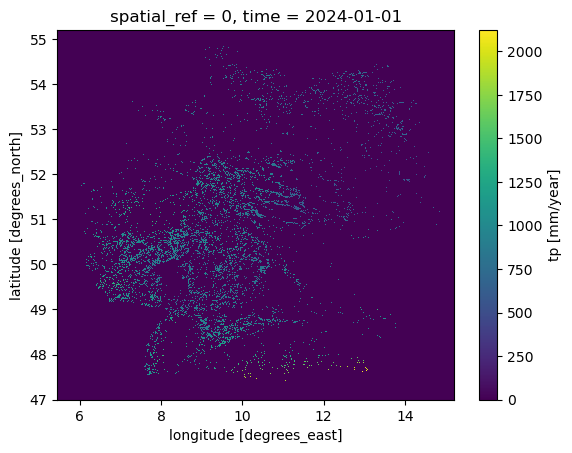

In [7]:
tp_year_sum.tp.plot()

In [8]:
# spatially aggregate yearly data
# to get summed values for Germany and federal states

In [9]:
# first, get values for broadleaved forest
# load all yearly tp values as one dataset
directory = f"./Climate/Precipitation/Yearly"
filelist = glob.glob(os.path.join(directory, "*BL*.nc"))
tp_yearly = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

In [10]:
# calculate summed values per year for Germany
tp_yearly_spatial_sums = tp_yearly.sum(['lon','lat'], skipna=True).to_dataframe()
tp_yearly_spatial_sums

,tp,spatial_ref
time,,
1981-01-01,4.432230e+08,0
1982-01-01,3.369496e+08,0
1983-01-01,3.541178e+08,0
1984-01-01,3.831963e+08,0
1985-01-01,3.359874e+08,0
1986-01-01,3.938619e+08,0
1987-01-01,3.944815e+08,0
1988-01-01,3.875263e+08,0
1989-01-01,3.149412e+08,0


In [11]:
# drop unneeded columns
tp_yearly_spatial_sums = tp_yearly_spatial_sums.drop(['spatial_ref'], axis=1)

In [12]:
# rename column with precipitation value to show area
tp_yearly_spatial_sums.rename({"tp":"GER"}, axis=1, inplace=True)

In [13]:
# now, calculate yearly summed values for all federal states
# get list of shapefiles of all states
directory = "./Administrative_Borders"
files = list(pathlib.Path(directory).glob('*.shp'))

# loop over filelist to process each state
for f in range(len(files)):
    file = files[f]

    # load state shapefile 
    state = str(file)[23:25]
    state_shp = gpd.read_file(file)

    # reproject shapefile to match netcdf data
    state_shp = state_shp.to_crs(4326)

    # extract one date to create mask of state with dimensions of data
    tp_ex = tp_yearly.sel(time = "1999-01-01", method = "nearest")

    # create mask of research area using the dimensions of the exemplary data
    state_mask = rasterio.features.geometry_mask(state_shp.geometry, 
                                                out_shape=tp_ex.odc.geobox.shape,
                                                transform=tp_ex.odc.geobox.affine,
                                                all_touched=False,
                                                invert=False)
    
    state_mask = xr.DataArray(state_mask, dims=("lat", "lon"))

    # mask yearly data
    tp_state = tp_yearly["tp"].where(~state_mask)

    # calculate yearly summed value of state and extract to dataframe
    tp_state_spatial_sums = tp_state.sum(['lon','lat'], skipna=True).to_dataframe()

    # drop unneeded columns
    tp_state_spatial_sums = tp_state_spatial_sums.drop(['spatial_ref'], axis=1)

    # add yearly summed values of state to dataframe
    tp_yearly_spatial_sums[state] = tp_state_spatial_sums["tp"]   

In [23]:
tp_yearly_spatial_sums = tp_yearly_spatial_sums.round(0)
tp_yearly_spatial_sums

,GER,BB,BE,BW,BY,HB,HE,HH,MV,NI,NW,RP,SH,SL,SN,ST,TH
time,,,,,,,,,,,,,,,,,
1981-01-01,1.016947e+09,140714799.0,2341366.0,130219383.0,286661739.0,204402.0,37801450.0,744651.0,34857256.0,98022143.0,78123685.0,26737902.0,6241304.0,1248665.0,65567534.0,43458055.0,64002342.0
1982-01-01,7.355547e+08,81973347.0,1467000.0,116224018.0,221556296.0,164641.0,28352078.0,592507.0,23294156.0,71891400.0,58059145.0,20993502.0,4990888.0,968581.0,36376264.0,26879986.0,41770862.0
1983-01-01,8.131799e+08,109523723.0,1909957.0,112731069.0,229309355.0,181016.0,29161313.0,663662.0,28821986.0,80643679.0,61271405.0,21446725.0,5473833.0,1064055.0,49092532.0,33205472.0,48680085.0
1984-01-01,8.334405e+08,108196303.0,1860824.0,108024802.0,227679880.0,194095.0,33492638.0,683349.0,28852506.0,88215283.0,69562360.0,24484256.0,5668407.0,1130436.0,45674644.0,34686867.0,55033802.0
1985-01-01,7.781580e+08,108580422.0,1811730.0,96379387.0,219831692.0,186772.0,28045792.0,697417.0,29070365.0,82079404.0,62287075.0,18912136.0,5666991.0,830404.0,46843867.0,32846181.0,44088330.0
1986-01-01,9.006961e+08,126968117.0,2141361.0,123006663.0,249097997.0,182865.0,33357519.0,652711.0,30202918.0,85703749.0,66419883.0,23731726.0,5466644.0,1154253.0,55214521.0,38236724.0,59158407.0
1987-01-01,9.075444e+08,127313420.0,2140322.0,114666509.0,257964332.0,201642.0,32595954.0,714171.0,31081318.0,91565179.0,68666239.0,23500300.0,5726857.0,1092851.0,57386720.0,38098496.0,54830072.0
1988-01-01,9.015561e+08,111031006.0,1849409.0,123854665.0,273095264.0,199219.0,31748440.0,714323.0,29393748.0,87964959.0,67550019.0,22717145.0,6031969.0,1122159.0,54018743.0,36065533.0,54199487.0
1989-01-01,7.173936e+08,87743559.0,1493670.0,90466658.0,218380543.0,168093.0,26500439.0,609441.0,21952090.0,72229388.0,54400756.0,19911906.0,4828216.0,930604.0,44396867.0,27499431.0,45881939.0


In [15]:
# save as csv dataset
tp_yearly_spatial_sums.to_csv("./Tables/Spatial_Means/Precipitation_Yearly_Spatial_Sums_BL.csv")

In [16]:
# now take the same steps for needleleaved forest
# load all yearly values as one dataset
directory = f"./Climate/Precipitation/Yearly"
filelist = glob.glob(os.path.join(directory, "*NL*.nc"))
tp_yearly = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

In [17]:
# calculate summed values per year for Germany
tp_yearly_spatial_sums = tp_yearly.sum(['lon','lat'], skipna=True).to_dataframe()

In [18]:
# drop unneeded columns
tp_yearly_spatial_sums = tp_yearly_spatial_sums.drop(['spatial_ref'], axis=1)

In [19]:
# rename column with precipitation value to show area
tp_yearly_spatial_sums.rename({"tp":"GER"}, axis=1, inplace=True)

In [20]:
# now, calculate yearly summed values for all federal states
# get list of shapefiles of all states
directory = "./Administrative_Borders"
files = list(pathlib.Path(directory).glob('*.shp'))

# loop over filelist to process each state
for f in range(len(files)):
    file = files[f]

    # load state shapefile 
    state = str(file)[23:25]
    state_shp = gpd.read_file(file)

    # reproject shapefile to match netcdf data
    state_shp = state_shp.to_crs(4326)

    # extract one date to create mask of state with dimensions of data
    tp_ex = tp_yearly.sel(time = "1999-01-01", method = "nearest")

    # create mask of research area using the dimensions of the exemplary data
    state_mask = rasterio.features.geometry_mask(state_shp.geometry, 
                                                out_shape=tp_ex.odc.geobox.shape,
                                                transform=tp_ex.odc.geobox.affine,
                                                all_touched=False,
                                                invert=False)
    
    state_mask = xr.DataArray(state_mask, dims=("lat", "lon"))

    # mask yearly data
    tp_state = tp_yearly["tp"].where(~state_mask)

    # calculate yearly sum of state and extract to dataframe
    tp_state_spatial_sums = tp_state.sum(['lon','lat'], skipna=True).to_dataframe()

    # drop unneeded columns
    tp_state_spatial_sums = tp_state_spatial_sums.drop(['spatial_ref'], axis=1)

    # add yearly summed values of state to dataframe
    tp_yearly_spatial_sums[state] = tp_state_spatial_sums["tp"]   

In [21]:
tp_yearly_spatial_sums

,GER,BB,BE,BW,BY,HB,HE,HH,MV,NI,NW,RP,SH,SL,SN,ST,TH
time,,,,,,,,,,,,,,,,,
1981-01-01,1.016947e+09,1.407148e+08,2.341366e+06,1.302194e+08,2.866617e+08,204402.207635,3.780145e+07,744650.582772,3.485726e+07,9.802214e+07,7.812368e+07,2.673790e+07,6.241304e+06,1.248665e+06,6.556753e+07,4.345805e+07,6.400234e+07
1982-01-01,7.355547e+08,8.197335e+07,1.467000e+06,1.162240e+08,2.215563e+08,164641.123693,2.835208e+07,592507.425553,2.329416e+07,7.189140e+07,5.805914e+07,2.099350e+07,4.990888e+06,9.685811e+05,3.637626e+07,2.687999e+07,4.177086e+07
1983-01-01,8.131799e+08,1.095237e+08,1.909957e+06,1.127311e+08,2.293094e+08,181016.036278,2.916131e+07,663661.948738,2.882199e+07,8.064368e+07,6.127141e+07,2.144673e+07,5.473833e+06,1.064055e+06,4.909253e+07,3.320547e+07,4.868008e+07
1984-01-01,8.334405e+08,1.081963e+08,1.860824e+06,1.080248e+08,2.276799e+08,194094.547531,3.349264e+07,683348.986726,2.885251e+07,8.821528e+07,6.956236e+07,2.448426e+07,5.668407e+06,1.130436e+06,4.567464e+07,3.468687e+07,5.503380e+07
1985-01-01,7.781580e+08,1.085804e+08,1.811730e+06,9.637939e+07,2.198317e+08,186772.277928,2.804579e+07,697417.329461,2.907036e+07,8.207940e+07,6.228707e+07,1.891214e+07,5.666991e+06,8.304037e+05,4.684387e+07,3.284618e+07,4.408833e+07
1986-01-01,9.006961e+08,1.269681e+08,2.141361e+06,1.230067e+08,2.490980e+08,182864.584941,3.335752e+07,652711.401273,3.020292e+07,8.570375e+07,6.641988e+07,2.373173e+07,5.466644e+06,1.154253e+06,5.521452e+07,3.823672e+07,5.915841e+07
1987-01-01,9.075444e+08,1.273134e+08,2.140322e+06,1.146665e+08,2.579643e+08,201641.961937,3.259595e+07,714170.742553,3.108132e+07,9.156518e+07,6.866624e+07,2.350030e+07,5.726857e+06,1.092851e+06,5.738672e+07,3.809850e+07,5.483007e+07
1988-01-01,9.015561e+08,1.110310e+08,1.849409e+06,1.238547e+08,2.730953e+08,199219.423453,3.174844e+07,714322.944663,2.939375e+07,8.796496e+07,6.755002e+07,2.271715e+07,6.031969e+06,1.122159e+06,5.401874e+07,3.606553e+07,5.419949e+07
1989-01-01,7.173936e+08,8.774356e+07,1.493670e+06,9.046666e+07,2.183805e+08,168093.402166,2.650044e+07,609440.996568,2.195209e+07,7.222939e+07,5.440076e+07,1.991191e+07,4.828216e+06,9.306040e+05,4.439687e+07,2.749943e+07,4.588194e+07


In [22]:
# save as csv dataset
tp_yearly_spatial_sums.to_csv("./Tables/Spatial_Means/Precipitation_Yearly_Spatial_Sums_NL.csv")